In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import cv2
import random
import yaml
import os
import json
import wandb
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.data.datasets import register_coco_instances

from detectron2.checkpoint import DetectionCheckpointer, Checkpointer

In [2]:
register_coco_instances("voxel", {}, "/data/detectron2/cropped_coco/cropped_2/coco_labels.json", "/data/detectron2/cropped_coco/cropped_2")
register_coco_instances("voxel_train", {}, "/data/detectron2/cropped_coco/cropped_2/train_labels.json", "/data/detectron2/cropped_coco/cropped_2")
register_coco_instances("voxel_test", {}, "/data/detectron2/cropped_coco/cropped_2/test_labels.json", "/data/detectron2/cropped_coco/cropped_2")
classes = ["PERSON", "PIT", "HARD_HAT", "SAFETY_VEST"]

WARNING [03/17 20:13:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/17 20:13:31 d2.data.datasets.coco]: Loaded 21838 images in COCO format from /data/detectron2/cropped_coco/cropped_2/train_labels.json
(Dataset: {'file_name': '/data/detectron2/cropped_coco/cropped_2/uscold_laredo_dock01_cha_20210525_121631_0017_frame_1740_21993/frame_21993.jpg', 'height': 248, 'width': 94, 'image_id': 18180, 'annotations': [{'iscrowd': 0, 'bbox': [0, 35, 78, 131], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [24, 1, 47, 42], 'category_id': 3, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


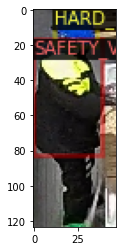

In [7]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("voxel_train")
dataset_dicts = DatasetCatalog.get("voxel_train")

# input()

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 1):
    print(f"(Dataset: {d}")
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [13]:
# Training
TOTAL_NUM_IMAGES = len(DatasetCatalog.get("voxel_train"))

cfg = get_cfg()
cfg.OUTPUT_DIR ="/home/vai_voxelsafety_com/models/detectron"
# Get the basic model configuration from the model zoo 
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) 
# Passing the Train and Validation sets
cfg.DATASETS.TRAIN = ("voxel_train",)
cfg.DATASETS.TEST = ("voxel_test",)
# Number of data loading threads
cfg.DATALOADER.NUM_WORKERS = 4
# initialize with pre-trained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  
# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LearningRate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #len(classes)
print(cfg.MODEL.ROI_HEADS.NUM_CLASSES)

cfg.SOLVER.NUM_GPUS = 1
single_iteration = cfg.SOLVER.NUM_GPUS * cfg.SOLVER.IMS_PER_BATCH
batches_per_epoch = int(TOTAL_NUM_IMAGES / single_iteration)
cfg.SOLVER.MAX_ITER = 500 #batches_per_epoch * epochs

print(f"output dir: {cfg.OUTPUT_DIR}")

cfg.TEST.EVAL_PERIOD = batches_per_epoch # do eval once per epoch. 

WARNING [03/17 20:21:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/17 20:21:38 d2.data.datasets.coco]: Loaded 21838 images in COCO format from /data/detectron2/cropped_coco/cropped_2/train_labels.json
80
output dir: /home/vai_voxelsafety_com/models/detectron
